## Introduction
In this tutorial on discrete registration we will explore the implementation of the correlation layer, used e.g. in FlowNet to compute a dissimilarity map for a range of discrete displacement. The method is demonstrated on slices of abomdinal CT scans from the TCIA pancreas dataset. 

## The whole picture
Extracted from the MICCAI submission (https://arxiv.org/pdf/1907.10931), the figure above illustrates the registration approach that will be implemented below.

The main idea is to incorporate learnable CNNs as feature extractors into an optimization pipeline that is inspired by a well studied discrete registration approach.

Archive:  Learn2Reg.zip


(-0.5, 693.5, 444.5, -0.5)

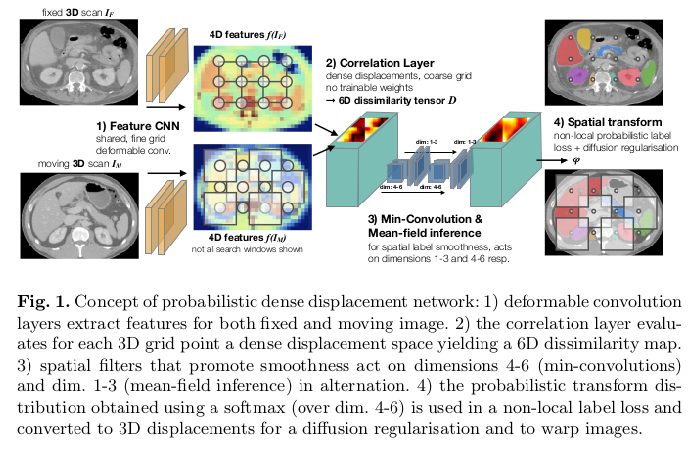

In [1]:
import os
!pip install -q wget
import wget


def get_data():
    filename = 'Learn2Reg.zip'
    if not os.path.exists(filename):
        filename = wget.download('https://cloud.imi.uni-luebeck.de/s/WnPcByW4zrDcrRA/download')
    
get_data()
!unzip -u 'Learn2Reg.zip'
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.imshow(plt.imread('Learn2Reg/concept_learn2reg.png'))
plt.axis('off')

## Importing provided helper functions
use "Add Data" > "Search by URL" > and type: kaggle.com/mattiaspaul/learn2reg to load the provided dataset, aside images and segmentations it contains the functions warp_and_evaluate, which is used to visualise your results and meanfield, which is required to regularise the probabilistic displacements

In [2]:
# This cell imports all requires packages and provides namespace aliases
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
print(os.listdir("Learn2Reg"))
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'Learn2Reg')

from learn2reg_discrete import *


['discrete_weights.png', 'tcia_prereg_2d_img.pth', 'cnn_matmul.png', 'unfold_tensors.png', 'tcia_prereg_2d_seg.pth', 'mindnet_cnn_pancreas.pth', 'learn2reg_tutorial-2.ipynb', 'concept_learn2reg.png', 'learn2reg_discrete.py']


# labels: 9


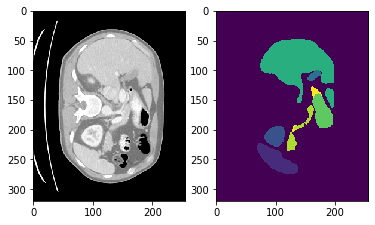

In [3]:
# Here, we import the image data and perform some preprocessing on the grayvalue images.
# In addition, to every slice, we provide organ segmentations that will be used for registration evaluation
# purposes (Dice scores) as well as for the weakly supervised training of the feature extraction 

# load TCIA data
imgs = torch.load('Learn2Reg/tcia_prereg_2d_img.pth').float()/255
segs = torch.load('Learn2Reg/tcia_prereg_2d_seg.pth').long()

# show an example patient slice
plt_pat = 17
plt.figure()
plt.subplot(121)
plt.imshow(imgs[plt_pat,:,:].cpu(),'gray')
plt.subplot(122)
plt.imshow(segs[plt_pat,:,:].cpu())

print('# labels:', segs.unique().size(0))

## Registration using pretrained CNNs
In the next cell, we load  pretrained network that computes features based on the input images (fixed and moving).

In [4]:
# Uncomment to use pretrained MIND-net to extract features
net = torch.load('Learn2Reg/mindnet_cnn_pancreas.pth')

torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0,17),torch.arange(18,43)),0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]
train_set = pat_indices[:35]
test_set = torch.cat((pat_indices[35:],torch.LongTensor([17])),0)

# Now, we prepare our train & test dataset. 
test_set = torch.LongTensor([35,41,0,4,33,38,39,17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

print('Test_Set:',test_set)
print('Train_Set:',train_set)

Test_Set: tensor([35, 41,  0,  4, 33, 38, 39, 17])
Train_Set: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 40, 42])


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.PReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or se

Now, we visualize a pair of images (fixed & moving), showing their grayvalue images, annotations and  feature representations.

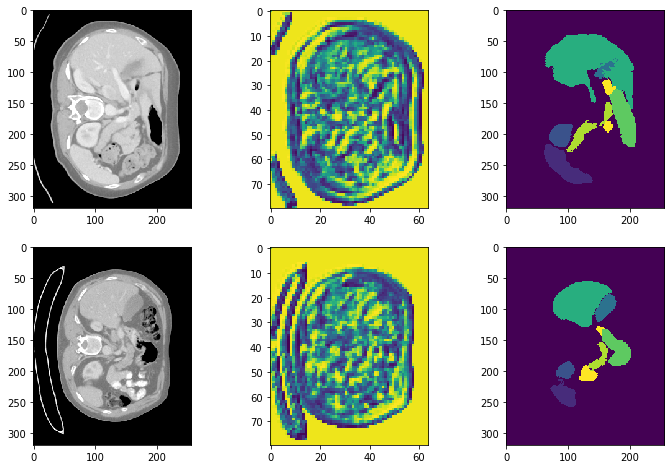

In [5]:
p_fix = train_set[9]
p_mov = train_set[15]


img_fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1)#.to(crnt_dev)
img_moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1)#.to(crnt_dev)
seg_fixed = segs[p_fix:p_fix+1,:,:]
seg_moving = segs[p_mov:p_mov+1,:,:]
feat_fixed = net(img_fixed)
feat_moving = net(img_moving)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(img_fixed[0,0,:,:].cpu().data,'gray')
plt.subplot(232)
plt.imshow(feat_fixed[0,0,:,:].cpu().data)
plt.subplot(233)
plt.imshow(seg_fixed[0,:,:].cpu().data)
plt.subplot(234)
plt.imshow(img_moving[0,0,:,:].cpu().data,'gray')
plt.subplot(235)
plt.imshow(feat_moving[0,0,:,:].cpu().data)
plt.subplot(236)
plt.imshow(seg_moving[0,:,:].cpu().data)
plt.show()

In the next part, for this image pair, we demonstrate the basic registration workflow, after having defined the discrete search region size:
1. compute the cost tensor using the correlation layer
2. compute the displacements using the meanfield function
3. applying the displacement field on the moving image with the warp_and_evaluate function

torch.Size([1, 24, 80, 64])
torch.Size([1, 81, 80, 64])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([5120, 81])


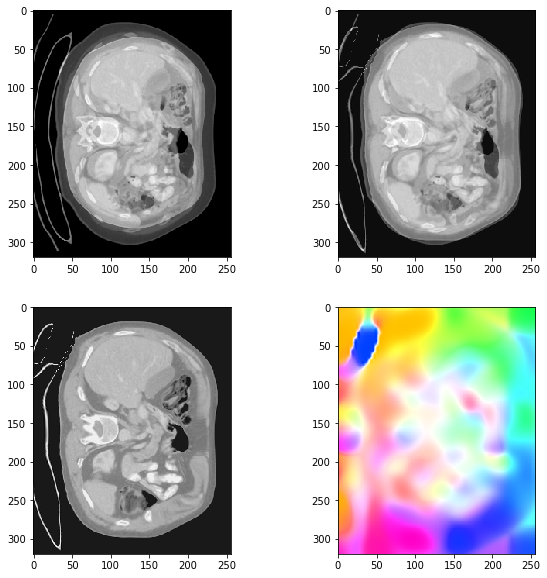

tensor([[0.3673, 1.0000],
        [0.6228, 2.0000],
        [0.5764, 3.0000],
        [0.6054, 5.0000],
        [0.5051, 6.0000],
        [0.2613, 7.0000]]) tensor(0.4897)
tensor([[0.6076, 1.0000],
        [0.6389, 2.0000],
        [0.5582, 3.0000],
        [0.7854, 5.0000],
        [0.5355, 6.0000],
        [0.3856, 7.0000]]) tensor(0.5852)


In [6]:
displace_range = 9
disp_hw = (displace_range-1)//2

B,C,H,W = feat_fixed.size()
print(feat_fixed.size())
ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
print(ssd_distance.size())
soft_cost,xi,yi = meanfield(ssd_distance, img_fixed, displace_range, H,W)
print(soft_cost.size())


warp_and_evaluate(xi,yi, img_fixed, img_moving, seg_fixed, seg_moving , displace_range, H, W)


## Training a CNN for registration
Next we will start implementing our own correlation layer and start training a network for discrete image registration

In [0]:
# The network defined here has the same architecture as the pretrained network above and we will train it from scratch 
# on the given image data.
net = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,24,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())


In [8]:
def my_correlation_layer(displace_range, feat_moving, feat_fixed):
    # TODO IMPLEMENT THE CORRELATION LAYER (or find the solution in learn2reg_discrete.py)
    
    # tensor dimensionalities in comments are for an arbitrary choice of
    # displace_range = 11 & feat sizes of [1,24,80,78];
    # they clearly depend on the actual choice and only serve as numerical examples here.
    
    disp_hw = (displace_range-1)//2
    # feat_mov: [1,24,80,78] -> 24 feature channels + spatial HW dims
    # feat_mov_unfold: [24,121,6240] -> mind chans, 11*11 = 121 displ steps, 6240 = 80*78 spatial positions
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    # feat_fixed: [24,1,6240] -> compute scalarproduct along feature dimension per broadcast + sum along 0
    # and reshape to [1,121,80,78]
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)
    #reshape the 4D tensor back to spatial dimensions
    return ssd_distance#.detach()
ssd_distance = my_correlation_layer(displace_range, feat_moving, feat_fixed)
print(ssd_distance.size())

torch.Size([1, 81, 80, 64])


In [9]:
#net = torch.load('mindnet_cnn.pth')
#move to GPU if available
gpu_flag = True

device_tensor = torch.ones(1)
crnt_dev = device_tensor.device
if gpu_flag:
    device_tensor = device_tensor.cuda()
    crnt_dev = device_tensor.device

print(crnt_dev)

net.to(crnt_dev)
net.train()

optimizer = optim.Adam(list(net.parameters()),lr=0.00025)

nr_train_pairs = 50
grad_accum = 4

for pdx in range(nr_train_pairs):
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    img_fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).to(crnt_dev)
    img_moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).to(crnt_dev)
    feat_fixed = net(img_fixed)
    feat_moving = net(img_moving)

    seg_fixed = segs[p_fix:p_fix+1,:,:]
    seg_moving = segs[p_mov:p_mov+1,:,:]
    
    label_moving = F.one_hot(seg_moving,num_classes=9).permute(0,3,1,2).float()
    _,C1,Hf,Wf = label_moving.size()
    label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
    label_fixed = F.one_hot(seg_fixed,num_classes=9).permute(0,3,1,2).float()
    label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
    # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
    # according to the corresponding discrete displacement pair
    label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,9,displace_range**2,-1)
    

    #forward path: pass both images through the network so that the weights appear in the computation graph
    # and will be updated
    feat_fixed = net(img_fixed)
    feat_moving = net(img_moving)
    # compute the cost tensor using the correlation layer
    ssd_distance = my_correlation_layer(displace_range, feat_moving, feat_fixed)
    
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost,xi,yi = meanfield(ssd_distance, img_fixed, displace_range, H, W)
    # loss computation:
    # compute the weighted sum of the shifted moving label versions 
    label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
    # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels
    label_distance1 = torch.sum(torch.pow(label_fixed.view(8,-1)-label_warped.view(8,-1),2),0)
    loss = label_distance1.mean()
    # perform the backpropagation and weight updates
    loss.backward()
    
    if (pdx+1)%grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer.step()
        optimizer.zero_grad()

    if(pdx%(nr_train_pairs/4)==((nr_train_pairs/4)-1)):
        print(pdx,loss.item())



cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


24 0.15264156460762024
49 0.11379417032003403


Next, we want to evaluate our network, that we trained from scratch on the held out test data

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


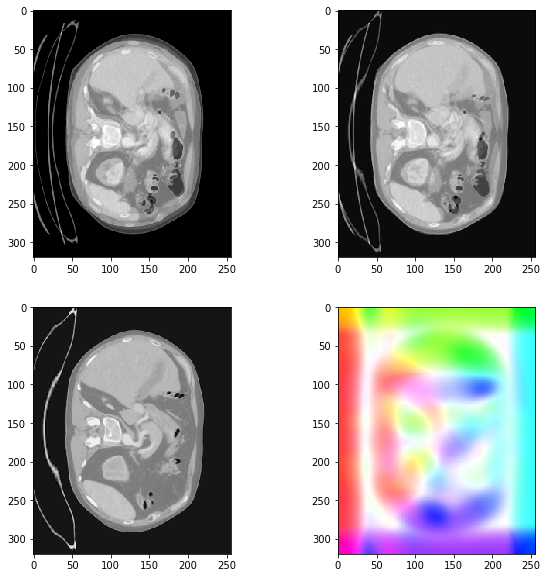

tensor([[0.6829, 1.0000],
        [0.5568, 2.0000],
        [0.6990, 5.0000],
        [0.7131, 6.0000],
        [0.2114, 7.0000],
        [0.0680, 8.0000]]) tensor(0.4885)
tensor([[0.9062, 1.0000],
        [0.7117, 2.0000],
        [0.7787, 5.0000],
        [0.6771, 6.0000],
        [0.3939, 7.0000],
        [0.1628, 8.0000]]) tensor(0.6051)


In [11]:
# Validate:
valid_pat_fix_idx = -1 # patient 17
valid_pat_mov_idx = 0

p_fix = test_set[valid_pat_fix_idx] # pat17
p_mov = test_set[valid_pat_mov_idx]


# 1) compute the feature representations
net = net.eval()
img_fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(1).to(crnt_dev)
img_moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(1).to(crnt_dev)
feat_fixed = net(img_fixed)
feat_moving = net(img_moving)

seg_fixed = segs[p_fix:p_fix+1,:,:]
seg_moving = segs[p_mov:p_mov+1,:,:]

# 2) perform the SSD cost calculation based on the correlation layer 
ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)


soft_cost,xi,yi = meanfield(ssd_distance, img_fixed, displace_range, H, W)

warp_and_evaluate(xi,yi, img_fixed, img_moving, seg_fixed, seg_moving , displace_range, H, W)

## Explanatory Details

### 2) Correlation layer implementation: Basic steps

#### CNN: Convolution operation
In order to "move" a filter kernel across an image, behind the scenes an __*unfold*__ operation is used to transfer this operation, i.e. the extraction of image patch sequences, into a matrix multiplication. Based on the kernel size, the patches are arranged into the "unfolded" matrix according to their position during the sweeping process of the convolution.
The image below illustrates this for an image that is convolved with a 2x2 kernel: consecutively, the red, green, yellow and blue patch are multiplied by the kernel to gain convolution output. Here, a [1,1,3,3] Image-Tensor (batch_sz, #channels, heigth, width) is convolved with a 2x2 kernel (without padding etc.), resulting in a [1,1,2,2] output. Without padding, we have 4 valid patches to apply the 2x2 kernel, therefore the "unfolded" matrix is of dimensionality [4x4].     



(-0.5, 2315.5, 522.5, -0.5)

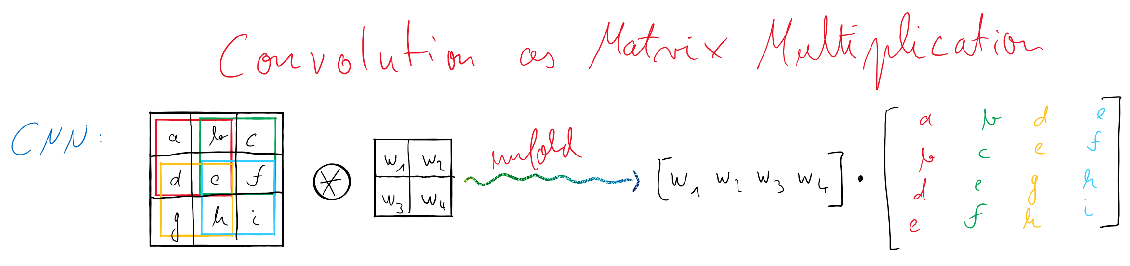

In [13]:
plt.figure(figsize=(20,8))
plt.imshow(plt.imread('Learn2Reg/cnn_matmul.png'))
plt.axis('off')

#### Correlation layer
This *unfolding* operation comes in very handy to implement the correlation layer, where we need to perform a similar operation. While during a convolution, we use the unfold operation to *extract image patches (__regions__)* to be multiplied with a kernel, for the correlation layer, we also need to *extract regions for our __similarity search__* on a predefined discrete neighbourhood grid. 

After having processed our registration image pair by a __CNN, whose weights will be adjusted,__ we try to find corresponding image contents (cf. the red T) inside the discretized neighbourhood (yellow rectangle). In the example below, the 3x3 search region is defined by discrete voxel displacement pairs in [-1,0,1]x[-1,0,1] on the current resolution and (-1,-1) ideally yields the position with the highest correlation. 

(-0.5, 2499.5, 1160.5, -0.5)

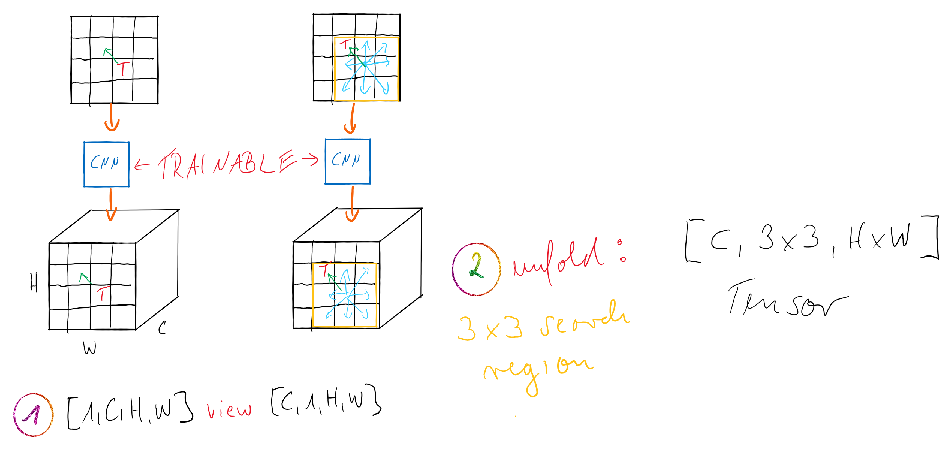

In [14]:
plt.figure(figsize=(20,8))
plt.imshow(plt.imread('Learn2Reg/unfold_tensors.png'))
plt.axis('off')

In order to compute the correlation values *for every voxel* in the moving image for *all discrete displacement steps in its corresponding search region* in the fixed image, we perform the following steps for an efficient implementation:
- We use the .view() operation to swap the batch and channel dimensions. For the sake of clarity, we process only one pair at a time. Pushing the channel into the batch dimension allows to leave the feature channels untouched, while "constructing" the search region patches along the first dimension with the *unfold* operation functionality. In essence, we change tensors [1, C, H, W] to [C, 1, H, W]. 
- Specifying the search region by (r_sz, r_sz) with r_sz being the size of the region, we use the unfold operation to obtain the "unfolded" tensor of dimension [C,r_sz x r_sz, H x W].
- Now, we are able to compute the sum of squared differences (SSD) values for every spatial position between the moving feature representation *m* and its corresponding search region feature representations in the fixed image *f*. Again, we use the .view() operation to transform the moving tensor [1,C,H,W] to [C,1,H x W]. Relying on the implicit broadcasting along the first dimension when computing (m-f)^2, we sum along the 0th dimension to obtain the SSD values for every spatial position in a tensor of dimension [r_sz x r_sz, H x W]. 

PyTorch documentation for the *unfold* operation: https://pytorch.org/docs/stable/nn.functional.html?highlight=unfold#torch.nn.functional.unfold


### 3) Min-Convolution
The finding of the displacement pair yielding the smallest SSD value corresponds to the idea of finding the feature representations that correlate the most. Since this process tends to be unstable due to noise or ambiguities, in the following, we introduce our two-fold regularisation strategy.  

In order to compute a reasonable displacement field, a two fold regularisation strategy is employed. Firstly, the subvoxel accuracy determination of the minimum SSD position inside the search region will be computed by a weighted averaging. Secondly, these values are subsequently also averaged along the spatial image dimensions to result in a smooth displacement field. 

For more theoretical insights, we refer you again to https://arxiv.org/pdf/1907.10931 and focus on the practical implementation details below.

For the subvoxel displacement parameter estimation per spatial position, we pursue the following strategy:
- Starting with the SSD tensor of size [r_sz x r_sz, H x W] computed in the last step above, we first perform the difussion regularisation using min-convolutions with a lower envelope of parabolas rooted at the displacement offsets with heights equalling the SSD values. This lower envelope is not directly differentiable, but we can obtain a very accurate approximation using first, a min-pooling (with stride=1) that finds local minima in the SSD tensor followed by two average pooling operations (with stride=1) that provide a quadratic smoothing.
- In order to obtain a reasonable displacement field, this next step is the mean-field inference. Here, we perform an average filtering along the spatial dimensions to get the final cost tensor. 

### 4) Spatial Transform
Performing 1 step of the discrete registration approach to check whether so far the implementation is working.
The refinement of the learnable feature CNN weights will be performed further down.

Here, the idea is to transfer the regularized cost tensor from above into a displacement field.

To achieve this, per spatial position, we combine weighted contributions of every possible displacement based on its cost determined by the correlation layer. In essence, applying the softmax function along the (negatively weighted) displacement dimension provides the weighting scheme for each displacement and their summation results in a smooth and continuous displacement per position.

(-0.5, 2483.5, 1208.5, -0.5)

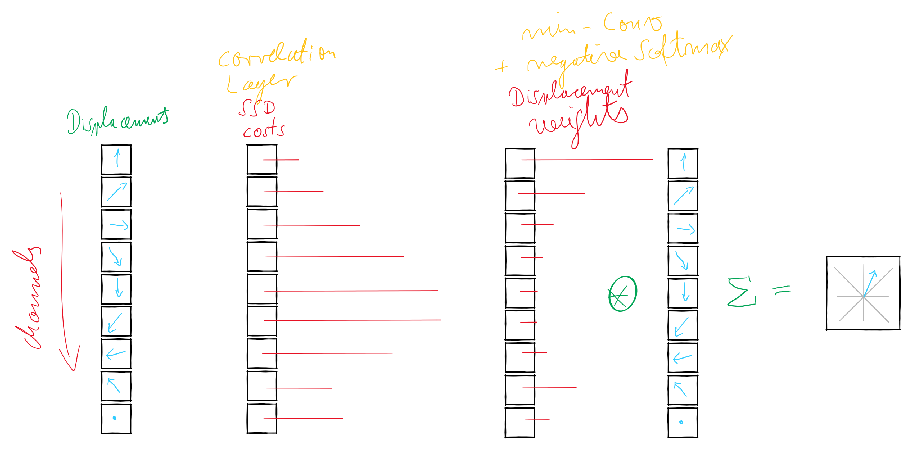

In [15]:
plt.figure(figsize=(20,8))
plt.imshow(plt.imread('Learn2Reg/discrete_weights.png'))
plt.axis('off')